## Importing all relevant modules

In [2]:

import requests
import json
from time import sleep
from bs4 import BeautifulSoup
from urllib.parse import unquote, quote
from datetime import datetime
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sb
import re

## Get list of all legislator bio links I want to scrape from:

In [4]:

user_agent = {'user-agent':'info-4871/0.0 Web Data Science, david.lapaglia@colorado.edu'}
root_url = 'https://leg.colorado.gov/legislators' #link with 'legislators'
root_url2 = 'https://leg.colorado.gov' # link without 'legislators'
raw_data = requests.get(
    root_url,
    headers = user_agent).text

leg_df = pd.read_html(raw_data)[0]


In [5]:
raw_soup = BeautifulSoup(raw_data,'html.parser') # turning raw HTML into soup
list_of_tags = [] # the goal is to store all the links into a list that I can iterate through later.
for x in raw_soup.find_all("tbody"):
    for i in x.find_all('a'):
        tag = i.get("href")
        if tag:
            list_of_tags.append(tag)
            #print(tag)
complete_list = []
counter = 0
for i in list_of_tags:
    complete_list.append(root_url2+list_of_tags[counter])
    counter+=1
complete_list # these is the correct amount of lists

['https://leg.colorado.gov/legislators/judy-amabile',
 'https://leg.colorado.gov/legislators/ryan-armagost',
 'https://leg.colorado.gov/legislators/jennifer-bacon',
 'https://leg.colorado.gov/legislators/mark-baisley',
 'https://leg.colorado.gov/legislators/shannon-bird',
 'https://leg.colorado.gov/legislators/rod-bockenfeld',
 'https://leg.colorado.gov/legislators/andrew-boesenecker',
 'https://leg.colorado.gov/legislators/scott-bottoms',
 'https://leg.colorado.gov/legislators/mary-bradfield',
 'https://leg.colorado.gov/legislators/brandi-bradley',
 'https://leg.colorado.gov/legislators/jeff-bridges',
 'https://leg.colorado.gov/legislators/kyle-brown',
 'https://leg.colorado.gov/legislators/janet-buckner',
 'https://leg.colorado.gov/legislators/marc-catlin',
 'https://leg.colorado.gov/legislators/chad-clifford',
 'https://leg.colorado.gov/legislators/james-coleman',
 'https://leg.colorado.gov/legislators/lisa-cutter',
 'https://leg.colorado.gov/legislators/jessie-danielson',
 'https:/

In [6]:
len(list_of_tags) # there are 100 total legislators, 35 senators and 65 representatives

100

In [7]:
# This cell was my experimentation retriveing specific data

raw_data = requests.get(complete_list[5],headers=user_agent).text # this only works for this guy, for others it doesn't work
leg_soup = BeautifulSoup(raw_data,'html.parser')


phone_number = leg_soup.find_all('div',{'class':'field-item even'})[4].text
party = leg_soup.find_all('div',{'class':'field-item even'})[2].text
address = leg_soup.find_all('div',{'class':'field-item even'})[3].text


# Gone minin' for districts
district = leg_soup.find_all('div', {'class': 'block-content'})[2]
district = district.find_all('div', {'class':'district'})[0]
district = district.find_all('div',{'class':'field-item even'})


# Gone minin' for counties
counties = leg_soup.find_all('div', {'class': 'block-content'})[2]
counties = counties.find_all('div',{'class':'counties'})[0]
counties = counties.find_all('div',{'class':'field-item even'})



In [8]:
# This is my main web scrapper, it takes a bit as it is requesting each 100 website. Load times are dependent on internet connection :)

# The way that it is working is that it is creating a dataframe and then gathering the data from each site and appening it to the PANDAS 
# dataframe. There are also some exception handling with basic if statements to still get my data based off of the legislators different
# websites.

counter = 0

#columns = ["Name",'Occupation','Assignment', "Address", "Party", "Phone Number", "District", "Counties"]
df_legislator = pd.DataFrame()


for i in range(100):
    raw_data = requests.get(complete_list[counter],headers=user_agent).text
    leg_soup = BeautifulSoup(raw_data,'html.parser')
    base = leg_soup.find_all('div', {'class': 'block-content'})[3] # I create seperate 'bases' where lots of info are stored.
    # gone minin' for phone numbers
    phone_number_b = leg_soup.find_all('div',{'class':'field field-name-field-contact-phone field-type-telephone field-label-above'})[0]
    phone_number = phone_number_b.find('div',{'class':"field-item even"}).text
    phone_number
    # gone minin' for parties
    party = leg_soup.find_all('div',{'class':'field-item even'})[2].text
    if party.lower() not in ['republican', 'democrat', 'independent']:
        party = leg_soup.find_all('div',{'class':'field-item even'})[1].text

    b_a = leg_soup.find("div",{"id":"block-cga-legislators-legislator-contact"})
    # gone minin' for addresses
    address = b_a.find_all('div',{'class':'field-item even'})
    address = address[0].text
    # gone minin' for names   
    name = leg_soup.find('h1',{'class':'node__title node-title'}).text

    
    # gone minin' for districts
    district_lst = []
    district = base.find_all('div', {'class': 'field-item even'})[0].text

            
    district_lst.append(district)
    
    
    # gone minin' for jobs
    occupation = leg_soup.find("div",{'class':"field field-name-field-occupation field-type-text field-label-above"})
    if occupation:
        occupation_text = occupation.find("div",{'class':"field-item"}).text
    else:
        occupation_text=''

    # gone minin' for emails
           
    email_b = leg_soup.find_all('a',{'class':'email-breakout-cta'})[0]
    email = email_b.get('href').replace("mailto:","")

    
    # gone minin' for assignments of committees
    b_c = leg_soup.find("div",{"id":"block-cga-legislators-committee-assignments"})
    if b_c:
                   
        assignmen = b_c.find_all('div',{'class':'committee-assignment'})[0]
        assignment = assignmen.find_all('h4',{'class':'committee-link'})[0]

        
        assignment_final = b_c.find_all('a')
        commitee_lst = []
        for c in assignment_final:
            print(c.text)
            commitee_lst.append(c.text)
        assignment = "; ".join(commitee_lst)

    else:
        assignment = ''

    

    # gone minin' for counties
    
    counties_lst = []
    counties_e = base.find_all('div', {'class': 'field-item even'}) # Counties even and odd, will have to skip the district number later
    counties_o = base.find_all('div', {'class': 'field-item odd'})

    
    for i in counties_e:
        counties_lst.append(i.text)
    for i in counties_o:
        counties_lst.append(i.text)
        
    # Take the information and combine it into a dictionary that will then be appended to df
    legislator_info = {
        "Name": name,
        'Occupation':occupation_text,
        "Address": address,
        'Assignment':assignment,
        "Party": party,
        "Phone Number": phone_number,
        "District": district_lst,
        "Counties": [", ".join(counties_lst[1:])],
        "Email": email
    }
    
    
    df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!
    
    print(name)# printing plenty of info so I can watch it collect move!
    print(occupation_text)
    print(address)
    print(assignment)
    print(party)
    print(phone_number)
    print(email)
    print(district_lst)
    print(counties_lst)


    counter+=1

Business Affairs & Labor
Appropriations
Legislative Council
Judiciary
Judy Amabile

200 E ColfaxRM 307Denver, CO 80203United States
Business Affairs & Labor; Appropriations; Legislative Council; Judiciary
Democrat
303-866-2578
judy.amabile.house@coleg.gov
['49']
['49', 'Boulder', 'Gilpin', 'Clear Creek', 'Larimer']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Business Affairs & Labor
Legislative Council
Judiciary
Ryan Armagost

200 E ColfaxRM 307Denver, CO 80203United States
Business Affairs & Labor; Legislative Council; Judiciary
Republican
303-866-2906
ryan.armagost.house@coleg.gov
['64']
['64', 'Larimer', 'Weld']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Judiciary
Education
Jennifer Bacon

200 E ColfaxRM 307Denver, CO 80203United States
Judiciary; Education
Democrat
303-866-2909
jennifer.bacon.house@coleg.gov
['7']
['7', 'Denver']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Business, Labor, & Technology
Joint Technology Committee
Education
State, Veterans, & Military Affairs
Mark Baisley
Aerospace Engineer
200 E ColfaxRMDenver, CO 80203United States
Business, Labor, & Technology; Joint Technology Committee; Education; State, Veterans, & Military Affairs
Republican
303-866-4877
mark.baisley@senate.co.com
['4']
['4', 'Chaffee', 'Douglas', 'Jefferson', 'Park', 'Custer', 'Fremont', 'Lake', 'Teller']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Appropriations
Joint Budget Committee
Shannon Bird

200 E ColfaxRM 307Denver, CO 80203United States
Appropriations; Joint Budget Committee
Democrat
303-866-2843
shannon.bird.house@coleg.gov
['29']
['29', 'Adams', 'Jefferson']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!
/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Rod Bockenfeld

200 E ColfaxRM 307Denver, CO 80203United States

Republican
303-866-2912
rod.bockenfeld.house@coleg.gov
['HB24-1144']
['HB24-1144', 'Concerning the creation of an income tax credit for sellers of residential real property that buy down the mortgage interest rate of the buyer of the property.', '2024 Regular Session', 'Bill', 'Fiscal Policy & Taxes', 'HB24-1109', 'Concerning the detention of a person arrested for committing a criminal offense while the person is on parole.', '2024 Regular Session', 'Bill', 'Crimes, Corrections, & Enforcement', 'HB24-1026', 'Concerning a requirement that voters reauthorize a local government to retain revenue in excess of the limitations imposed by section 20 of article X of the state constitution.', '2024 Regular Session', 'Bill', 'Fiscal Policy & Taxes']
Legislative Audit Committee
State, Civic, Military, & Veterans Affairs
Appropriations
Transportation, Housing & Local Government
Andrew Boesenecker

200 E ColfaxRM 307Denver, CO 80203Un

/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Appropriations
State, Civic, Military, & Veterans Affairs
Energy & Environment
Scott Bottoms

200 E ColfaxRM 307Denver, CO 80203United States
Appropriations; State, Civic, Military, & Veterans Affairs; Energy & Environment
Republican
303-866-5525
scott.bottoms.house@coleg.gov
['15']
['15', 'El Paso']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Education
Health & Human Services
Mary Bradfield

200 E ColfaxRM 307Denver, CO 80203United States
Education; Health & Human Services
Republican
303-866-2946
mary.bradfield.house@coleg.gov
['21']
['21', 'El Paso']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Health & Human Services
Statutory Revision Committee
State, Civic, Military, & Veterans Affairs
Brandi Bradley

200 E ColfaxRM 307Denver, CO 80203United States
Health & Human Services; Statutory Revision Committee; State, Civic, Military, & Veterans Affairs
Republican
303-866-2935
brandi.bradley.house@coleg.gov
['39']
['39', 'Douglas']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Appropriations
Joint Budget Committee
Jeff Bridges
Legislator
200 E ColfaxRMDenver, CO 80203United States
Appropriations; Joint Budget Committee
Democrat
303-866-4846
jeff.bridges.senate@coleg.gov
['26']
['26', 'Arapahoe', 'Jefferson', 'Denver']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Health & Human Services
State, Civic, Military, & Veterans Affairs
Kyle Brown

200 E ColfaxRM 307Denver, CO 80203United States
Health & Human Services; State, Civic, Military, & Veterans Affairs
Democrat
303-866-2920
kyle.brown.house@coleg.gov
['12']
['12', 'Boulder', 'Broomfield']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Education
Finance
Janet Buckner

200 E ColfaxRM 346Denver, CO 80203United States
Education; Finance
Democrat
303-866-3432
janet.buckner.senate@coleg.gov
['29']
['29', 'Arapahoe']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Agriculture, Water & Natural Resources
Capital Development Committee
Transportation, Housing & Local Government
Marc Catlin
Legislator
200 E ColfaxRM 307Denver, CO 80203United States
Agriculture, Water & Natural Resources; Capital Development Committee; Transportation, Housing & Local Government
Republican
303-866-2955
marc.catlin.house@coleg.gov
['58']
['58', 'Delta', 'Gunnison', 'Montezuma', 'Ouray', 'Dolores', 'Hinsdale', 'Montrose', 'San Miguel']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Business Affairs & Labor
Chad Clifford

200 E ColfaxRM 307Denver, CO 80203United States
Business Affairs & Labor
Democrat
303-866-5510
chad.clifford.house@coleg.gov
['37']
['37', 'Arapahoe']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


State, Veterans, & Military Affairs
Appropriations
Legislative Council
Business, Labor, & Technology
James Coleman
Legislator
200 E ColfaxRM 346Denver, CO 80203United States
State, Veterans, & Military Affairs; Appropriations; Legislative Council; Business, Labor, & Technology
Democrat
303-866-4864
james.coleman.senate@coleg.gov
['33']
['33', 'Denver']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Transportation & Energy
Health & Human Services
Lisa Cutter

200 E ColfaxRM 346Denver, CO 80203United States
Transportation & Energy; Health & Human Services
Democrat
303-866-4859
lisa.cutter.senate@coleg.gov
['20']
['20', 'Jefferson']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Agriculture & Natural Resources
Business, Labor, & Technology
Jessie Danielson

200 E ColfaxRM 346Denver, CO 80203United States
Agriculture & Natural Resources; Business, Labor, & Technology
Democrat
303-866-4856
jessie.danielson.senate@coleg.gov
['22']
['22', 'Jefferson']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Health & Human Services
Committee on Legal Services
Lindsey Daugherty

200 E ColfaxRM 307Denver, CO 80203United States
Health & Human Services; Committee on Legal Services
Democrat
303-866-2950
lindsey.daugherty.house@coleg.gov
['24']
['24', 'Adams', 'Jefferson']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Energy & Environment
State, Civic, Military, & Veterans Affairs
Ken DeGraaf

200 E ColfaxRM 307Denver, CO 80203United States
Energy & Environment; State, Civic, Military, & Veterans Affairs
Republican
303-866-2927
ken.degraaf.house@coleg.gov
['22']
['22', 'El Paso']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Finance
Legislative Council
Chris deGruy Kennedy

200 E ColfaxRM 307Denver, CO 80203United States
Finance; Legislative Council
Democrat
303-866-2951
chris.kennedy.house@coleg.gov
['30']
['30', 'Jefferson']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Executive Committee of the Legislative Council
Legislative Council
Monica Duran

200 E ColfaxRM 307Denver, CO 80203United States
Executive Committee of the Legislative Council; Legislative Council
Democrat
303-866-5522
monica.duran.house@coleg.gov
['23']
['23', 'Jefferson']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Business Affairs & Labor
Health & Human Services
Regina English

200 E ColfaxRM 307Denver, CO 80203United States
Business Affairs & Labor; Health & Human Services
Democrat
303-866-3069
regina.english.house@coleg.gov
['17']
['17', 'El Paso']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


State, Civic, Military, & Veterans Affairs
Statutory Revision Committee
Elisabeth Epps

200 E ColfaxRM 307Denver, CO 80203United States
State, Civic, Military, & Veterans Affairs; Statutory Revision Committee
Democrat
303-866-2911
elisabeth.epps.house@coleg.gov
['6']
['6', 'Denver']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Energy & Environment
Legislative Audit Committee
Judiciary
Gabe Evans

200 E ColfaxRM 307Denver, CO 80203United States
Energy & Environment; Legislative Audit Committee; Judiciary
Republican
303-866-2943
gabe.evans.house@coleg.gov
['48']
['48', 'Adams', 'Weld']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Local Government & Housing
Transportation & Energy
Tony Exum

200 E ColfaxRM 346Denver, CO 80203United States
Local Government & Housing; Transportation & Energy
Democrat
303-866-6364
tony.exum.senate@coleg.gov
['11']
['11', 'El Paso']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Executive Committee of the Legislative Council
Legislative Council
Capitol Building Advisory Committee
Steve Fenberg

200 E ColfaxDenver, CO 80203United States
Executive Committee of the Legislative Council; Legislative Council; Capitol Building Advisory Committee
Democrat
303-866-4872
stephen.fenberg.senate@coleg.gov
['18']
['18', 'Boulder']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Health & Human Services
Education
Rhonda Fields
Legislator
200 E ColfaxRMDenver, CO 80203United States
Health & Human Services; Education
Democrat
303-866-4879
rhonda.fields.senate@coleg.gov
['28']
['28', 'Adams', 'Arapahoe']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Legislative Audit Committee
Appropriations
Finance
Business Affairs & Labor
Transportation, Housing & Local Government
Lisa Frizell

200 E ColfaxRM 307Denver, CO 80203United States
Legislative Audit Committee; Appropriations; Finance; Business Affairs & Labor; Transportation, Housing & Local Government
Republican
303-866-2948
lisa.frizell.house@coleg.gov
['45']
['45', 'Douglas']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Transportation, Housing & Local Government
Energy & Environment
Meg Froelich
Legislator
200 E ColfaxRM 307Denver, CO 80203United States
Transportation, Housing & Local Government; Energy & Environment
Democrat
303-866-2921
meg.froelich.house@coleg.gov
['3']
['3', 'Arapahoe', 'Denver']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Finance
Judiciary
Lorena Garcia
Legislator
200 E ColfaxRM 307Denver, CO 80203United States
Finance; Judiciary
Democrat
303-866-2964
lorena.garcia.house@coleg.gov
['35']
['35', 'Adams', 'Jefferson']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Committee on Legal Services
Appropriations
Legislative Council
Judiciary
Bob Gardner

200 E ColfaxRMDenver, CO 80203United States
Committee on Legal Services; Appropriations; Legislative Council; Judiciary
Republican
303-866-4880
bob.gardner.senate@coleg.gov
['12']
['12', 'El Paso', 'Teller']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Health & Human Services
Business, Labor, & Technology
Statutory Revision Committee
Joann Ginal
Reproductive Endocrinologist
200 E ColfaxRM 346Denver, CO 80203United States
Health & Human Services; Business, Labor, & Technology; Statutory Revision Committee
Democrat
303-866-4841
joann.ginal.senate@coleg.gov
['14']
['14', 'Larimer']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Judiciary
Local Government & Housing
Appropriations
Legislative Audit Committee
Committee on Legal Services
Julie Gonzales
Senator
200 E ColfaxRM 346Denver, CO 80203United States
Judiciary; Local Government & Housing; Appropriations; Legislative Audit Committee; Committee on Legal Services
Democrat
303-866-4862
julie.gonzales.senate@coleg.gov
['34']
['34', 'Denver']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Pension Review Subcommittee
Education
Health & Human Services
Eliza Hamrick

200 E ColfaxRM 307Denver, CO 80203United States
Pension Review Subcommittee; Education; Health & Human Services
Democrat
303-866-3706
eliza.hamrick.house@coleg.gov
['61']
['61', 'Arapahoe', 'Douglas']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Appropriations
Joint Technology Committee
Committee on Legal Services
Legislative Council
Finance
State, Veterans, & Military Affairs
Chris Hansen
Non-Profit Director
200 E ColfaxRMDenver, CO 80203United States
Appropriations; Joint Technology Committee; Committee on Legal Services; Legislative Council; Finance; State, Veterans, & Military Affairs
Democrat
303-866-4861
chris.hansen.senate@coleg.gov
['31']
['31', 'Denver']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Education
Legislative Council
Finance
Anthony Hartsook

200 E ColfaxRM 307Denver, CO 80203United States
Education; Legislative Council; Finance
Republican
303-866-2933
anthony.hartsook.house@coleg.gov
['44']
['44', 'Douglas']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Health & Human Services
Tim Hernandez

200 E ColfaxRM 307Denver, CO 80203United States
Health & Human Services
Democrat
303-866-2954
tim.hernandez.house@coleg.gov
['4']
['4', 'Denver']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Appropriations
Judiciary
Leslie Herod
Legislator
200 E ColfaxRM 307Denver, CO 80203United States
Appropriations; Judiciary
Democrat
303-866-2959
leslie.herod.house@coleg.gov
['8']
['8', 'Denver']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Business, Labor, & Technology
Capital Development Committee
Statutory Revision Committee
Transportation & Energy
Nick Hinrichsen

200 E ColfaxRM 346Denver, CO 80203United States
Business, Labor, & Technology; Capital Development Committee; Statutory Revision Committee; Transportation & Energy
Democrat
303-866-4878
nick.hinrichsen.senate@coleg.gov
['3']
['3', 'Pueblo']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Agriculture, Water & Natural Resources
Health & Human Services
Richard Holtorf

200 E ColfaxRM 307Denver, CO 80203United States
Agriculture, Water & Natural Resources; Health & Human Services
Republican
303-866-2398
richard.holtorf.house@coleg.gov
['63']
['63', 'Logan', 'Phillips', 'Washington', 'Yuma', 'Morgan', 'Sedgwick', 'Weld']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Health & Human Services
Local Government & Housing
Sonya Jaquez Lewis
Pharmacist
200 E ColfaxRM 346Denver, CO 80203United States
Health & Human Services; Local Government & Housing
Democrat
303-866-5291
sonya.jaquez.lewis.senate@coleg.gov
['17']
['17', 'Boulder', 'Weld', 'Broomfield']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Appropriations
Transportation, Housing & Local Government
Legislative Council
Iman Jodeh

200 E ColfaxRM 307Denver, CO 80203United States
Appropriations; Transportation, Housing & Local Government; Legislative Council
Democrat
303-866-2919
Iman.Jodeh.house@coleg.gov
['41']
['41', 'Arapahoe']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Finance
Energy & Environment
Junie Joseph

200 E ColfaxRM 307Denver, CO 80203United States
Finance; Energy & Environment
Democrat
303-866-2915
junie.joseph.house@coleg.gov
['10']
['10', 'Boulder']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Energy & Environment
Finance
Cathy Kipp
 
200 E ColfaxRM 307Denver, CO 80203United States
Energy & Environment; Finance
Democrat
303-866-4569
cathy.kipp.house@coleg.gov
['52']
['52', 'Larimer']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Appropriations
Joint Budget Committee
Barbara Kirkmeyer
Legislator
200 E ColfaxRM 346Denver, CO 80203United States
Appropriations; Joint Budget Committee
Republican
303-866-4876
barbara.kirkmeyer.senate@coleg.gov
['23']
['23', 'Larimer', 'Weld']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Finance
Pension Review Subcommittee
Education
Chris Kolker

200 E ColfaxRM 346Denver, CO 80203United States
Finance; Pension Review Subcommittee; Education
Democrat
303-866-4883
chris.kolker.senate@coleg.gov
['16']
['16', 'Arapahoe', 'Jefferson']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Business Affairs & Labor
Health & Human Services
Sheila Lieder

200 E ColfaxRM 307Denver, CO 80203United States
Business Affairs & Labor; Health & Human Services
Democrat
303-866-2939
sheila.lieder.house@coleg.gov
['28']
['28', 'Jefferson']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Transportation, Housing & Local Government
Agriculture, Water & Natural Resources
Capital Development Committee
Mandy Lindsay

200 E ColfaxRM 307Denver, CO 80203United States
Transportation, Housing & Local Government; Agriculture, Water & Natural Resources; Capital Development Committee
Democrat
303-866-3911
mandy.lindsay.house@coleg.gov
['42']
['42', 'Arapahoe']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Business Affairs & Labor
Finance
Capitol Building Advisory Committee
Legislative Audit Committee
William Lindstedt

200 E ColfaxRM 307Denver, CO 80203United States
Business Affairs & Labor; Finance; Capitol Building Advisory Committee; Legislative Audit Committee
Democrat
303-866-4667
william.lindstedt.house@coleg.gov
['33']
['33', 'Adams', 'Weld', 'Broomfield']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Appropriations
Pension Review Subcommittee
Business, Labor, & Technology
State, Veterans, & Military Affairs
Larry Liston

200 E ColfaxRM 346Denver, CO 80203United States
Appropriations; Pension Review Subcommittee; Business, Labor, & Technology; State, Veterans, & Military Affairs
Republican
303-866-2737
larry.liston.senate@coleg.gov
['10']
['10', 'El Paso']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Appropriations
Stephanie Luck

200 E ColfaxRM 307Denver, CO 80203United States
Appropriations
Republican
303-866-2905
stephanie.luck.house@coleg.gov
['60']
['60', 'Chaffee', 'Fremont', 'Teller', 'Custer', 'Pueblo']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Agriculture, Water & Natural Resources
Legislative Council
Education
Meghan Lukens
Teacher
200 E ColfaxRM 307Denver, CO 80203United States
Agriculture, Water & Natural Resources; Legislative Council; Education
Democrat
303-866-2923
meghan.lukens.house@coleg.gov
['26']
['26', 'Eagle', 'Rio Blanco', 'Moffat', 'Routt']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Education
Legislative Council
Executive Committee of the Legislative Council
Paul Lundeen

200 E ColfaxRM 346Denver, CO 80203United States
Education; Legislative Council; Executive Committee of the Legislative Council
Republican
303-866-4835
paul.lundeen.senate@coleg.gov
['9']
['9', 'El Paso']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Agriculture, Water & Natural Resources
Business Affairs & Labor
Mike Lynch

200 E ColfaxRM 307Denver, CO 80203United States
Agriculture, Water & Natural Resources; Business Affairs & Labor
Republican
303-866-2907
mike.lynch.house@coleg.gov
['65']
['65', 'Larimer', 'Weld']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Business Affairs & Labor
Judiciary
Committee on Legal Services
Javier Mabrey

200 E ColfaxRM 307Denver, CO 80203United States
Business Affairs & Labor; Judiciary; Committee on Legal Services
Democrat
303-866-2966
javier.mabrey.house@coleg.gov
['1']
['1', 'Denver', 'Jefferson']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Education
Agriculture & Natural Resources
Janice Marchman
Teacher
200 E ColfaxRM 346Denver, CO 80203United States
Education; Agriculture & Natural Resources
Democrat
303-866-4853
janice.marchman.senate@coleg.gov
['15']
['15', 'Boulder', 'Larimer']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Finance
Bob Marshall

200 E ColfaxRM 307Denver, CO 80203United States
Finance
Democrat
303-866-2936
bob.marshall.house@coleg.gov
['43']
['43', 'Douglas']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Education
Agriculture, Water & Natural Resources
Matthew Martinez
Higher Education
200 E ColfaxRM 307Denver, CO 80203United States
Education; Agriculture, Water & Natural Resources
Democrat
303-866-2916
matthew.martinez.house@coleg.gov
['62']
['62', 'Alamosa', 'Costilla', 'Mineral', 'Rio Grande', 'Conejos', 'Huerfano', 'Pueblo', 'Saguache']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Agriculture, Water & Natural Resources
Julia Marvin

200 E ColfaxRM 307Denver, CO 80203United States
Agriculture, Water & Natural Resources
Democrat
303-866-2918
julia.marvin.house@coleg.gov
['31']
['31', 'Adams']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Business Affairs & Labor
Transportation, Housing & Local Government
Tisha Mauro

200 E ColfaxRM 307Denver, CO 80203United States
Business Affairs & Labor; Transportation, Housing & Local Government
Democrat
303-866-2968
tisha.mauro.house@coleg.gov
['46']
['46', 'Pueblo']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Executive Committee of the Legislative Council
Legislative Council
Julie McCluskie

200 E ColfaxRM 307Denver, CO 80203United States
Executive Committee of the Legislative Council; Legislative Council
Democrat
303-866-2952
Julie.Mccluskie.house@coleg.gov
['13']
['13', 'Chaffee', 'Jackson', 'Park', 'Grand', 'Lake', 'Summit']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Agriculture, Water & Natural Resources
Health & Human Services
Karen McCormick
Veterinarian
200 E ColfaxRM 307Denver, CO 80203United States
Agriculture, Water & Natural Resources; Health & Human Services
Democrat
303-866-2780
karen.mccormick.house@coleg.gov
['11']
['11', 'Boulder']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Education
Statutory Revision Committee
Agriculture, Water & Natural Resources
Barbara McLachlan
Legislator
200 E ColfaxRM 307Denver, CO 80203United States
Education; Statutory Revision Committee; Agriculture, Water & Natural Resources
Democrat
303-866-2914
barbara.mclachlan.house@coleg.gov
['59']
['59', 'Archuleta', 'Montezuma', 'La Plata', 'San Juan']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Health & Human Services
Legislative Audit Committee
Judiciary
Dafna Michaelson Jenet

200 E ColfaxDenver, CO 80203United States
Health & Human Services; Legislative Audit Committee; Judiciary
Democrat
303-866-4857
dafna.michaelson.jenet.senate@coleg.gov
['21']
['21', 'Adams', 'Arapahoe']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Finance
Capital Development Committee
Health & Human Services
Kyle Mullica

200 E ColfaxRM 346Denver, CO 80203United States
Finance; Capital Development Committee; Health & Human Services
Democrat
303-866-4451
kyle.mullica.senate@coleg.gov
['24']
['24', 'Adams']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Health & Human Services
David Ortiz

200 E ColfaxRM 307Denver, CO 80203United States
Health & Human Services
Democrat
303-866-2953
David.Ortiz.house@coleg.gov
['38']
['38', 'Arapahoe', 'Jefferson']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Joint Technology Committee
Transportation, Housing & Local Government
State, Civic, Military, & Veterans Affairs
Jennifer Lea Parenti

200 E ColfaxRM 307Denver, CO 80203United States
Joint Technology Committee; Transportation, Housing & Local Government; State, Civic, Military, & Veterans Affairs
Democrat
303-866-2924
jennifer.parenti.house@coleg.gov
['19']
['19', 'Boulder', 'Weld']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Statutory Revision Committee
Agriculture & Natural Resources
Local Government & Housing
Capital Development Committee
Transportation & Energy
Byron Pelton
Electrician / Rancher
200 E ColfaxRM 346Denver, CO 80203United States
Statutory Revision Committee; Agriculture & Natural Resources; Local Government & Housing; Capital Development Committee; Transportation & Energy
Republican
303-866-6360
byron.pelton.senate@coleg.gov
['1']
['1', 'Logan', 'Phillips', 'Washington', 'Yuma', 'Morgan', 'Sedgwick', 'Weld']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Agriculture & Natural Resources
Local Government & Housing
Legislative Audit Committee
Rod Pelton

200 E ColfaxRM 346Denver, CO 80203United States
Agriculture & Natural Resources; Local Government & Housing; Legislative Audit Committee
Republican
303-866-4884
rod.pelton.senate@coleg.gov
['35']
['35', 'Baca', 'Cheyenne', 'El Paso', 'Huerfano', 'Kit Carson', 'Lincoln', 'Prowers', 'Bent', 'Crowley', 'Elbert', 'Kiowa', 'Las Animas', 'Otero']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Joint Technology Committee
Transportation & Energy
Agriculture & Natural Resources
Appropriations
Kevin Priola

200 E ColfaxRM 346Denver, CO 80203United States
Joint Technology Committee; Transportation & Energy; Agriculture & Natural Resources; Appropriations
Democrat
303-866-4855
kevin.priola.senate@coleg.gov
['13']
['13', 'Adams', 'Weld']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Education
Legislative Council
Executive Committee of the Legislative Council
Statutory Revision Committee
Rose Pugliese

200 E ColfaxRM 307Denver, CO 80203United States
Education; Legislative Council; Executive Committee of the Legislative Council; Statutory Revision Committee
Republican
303-866-2965
rose.pugliese.house@coleg.gov
['14']
['14', 'El Paso']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Education
Local Government & Housing
Health & Human Services
Statutory Revision Committee
Janice Rich

200 E ColfaxRM 346Denver, CO 80203United States
Education; Local Government & Housing; Health & Human Services; Statutory Revision Committee
Republican
303-866-3077
janicerichsd7@gmail.com
['7']
['7', 'Delta', 'Mesa']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Business Affairs & Labor
State, Civic, Military, & Veterans Affairs
Naquetta Ricks

200 E ColfaxRM 307Denver, CO 80203United States
Business Affairs & Labor; State, Civic, Military, & Veterans Affairs
Democrat
303-866-2944
Naquetta.Ricks.house@coleg.gov
['40']
['40', 'Arapahoe']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Agriculture & Natural Resources
Judiciary
Committee on Legal Services
Dylan Roberts
Attorney
200 E ColfaxRM 346Denver, CO 80203United States
Agriculture & Natural Resources; Judiciary; Committee on Legal Services
Democrat
303-866-4871
dylan.roberts.senate@coleg.gov
['8']
['8', 'Clear Creek', 'Garfield', 'Grand', 'Moffat', 'Routt', 'Eagle', 'Gilpin', 'Jackson', 'Rio Blanco', 'Summit']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Executive Committee of the Legislative Council
Legislative Council
Robert Rodriguez

200 E ColfaxRM 346Denver, CO 80203United States
Executive Committee of the Legislative Council; Legislative Council
Democrat
303-866-4852
robert.rodriguez.senate@coleg.gov
['32']
['32', 'Arapahoe', 'Jefferson', 'Denver']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Energy & Environment
State, Civic, Military, & Veterans Affairs
Manny Rutinel
Attorney
200 E ColfaxRM 307Denver, CO 80203United States
Energy & Environment; State, Civic, Military, & Veterans Affairs
Democrat
303-866-2945
manny.rutinel.house@coleg.gov
['32']
['32', 'Adams']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Agriculture & Natural Resources
Legislative Council
Finance
Transportation & Energy
Cleave Simpson
Farmer/Rancher
200 E ColfaxRM 346Denver, CO 80203United States
Agriculture & Natural Resources; Legislative Council; Finance; Transportation & Energy
Republican
303-866-4875
cleave.simpson.senate@coleg.gov
['6']
['6', 'Alamosa', 'Conejos', 'Dolores', 'Mineral', 'Montrose', 'Rio Grande', 'San Juan', 'Archuleta', 'Costilla', 'La Plata', 'Montezuma', 'Ouray', 'Saguache', 'San Miguel']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Appropriations
Joint Budget Committee
Emily Sirota
Administrator/Social Worker
200 E ColfaxRM 307Denver, CO 80203United States
Appropriations; Joint Budget Committee
Democrat
303-866-2910
emily.sirota.house@coleg.gov
['9']
['9', 'Arapahoe', 'Denver']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Finance
Legislative Council
Health & Human Services
Jim Smallwood

200 E ColfaxRM 346Denver, CO 80203United States
Finance; Legislative Council; Health & Human Services
Republican
303-866-4869
SenatorSmallwood@gmail.com
['2']
['2', 'Douglas']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Finance
Judiciary
Marc Snyder
Attorney
200 E ColfaxRM 307Denver, CO 80203United States
Finance; Judiciary
Democrat
303-866-2932
marc.snyder.house@coleg.gov
['18']
['18', 'El Paso', 'Teller']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Committee on Legal Services
Judiciary
Finance
Matt Soper
Professional Researcher and Writer
200 E ColfaxRM 307Denver, CO 80203United States
Committee on Legal Services; Judiciary; Finance
Republican
303-866-2583
matthew.soper.house@coleg.gov
['54']
['54', 'Delta', 'Mesa']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Capital Development Committee
Agriculture, Water & Natural Resources
Education
Tammy Story

200 E ColfaxRM 307Denver, CO 80203United States
Capital Development Committee; Agriculture, Water & Natural Resources; Education
Democrat
303-866-2582
tammy.story.house@coleg.gov
['25']
['25', 'Jefferson']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


State, Veterans, & Military Affairs
Business, Labor, & Technology
Tom Sullivan

200 E ColfaxRM 346Denver, CO 80203United States
State, Veterans, & Military Affairs; Business, Labor, & Technology
Democrat
303-866-4873
tom.sullivan.senate@coleg.gov
['27']
['27', 'Arapahoe', 'Douglas']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Appropriations
Joint Budget Committee
Rick Taggart

200 E ColfaxRM 307Denver, CO 80203United States
Appropriations; Joint Budget Committee
Republican
303-866-3068
rick.taggart.house@coleg.gov
['55']
['55', 'Mesa']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Joint Technology Committee
Agriculture, Water & Natural Resources
Energy & Environment
Brianna Titone
Geologist/Software Dev.
200 E ColfaxRM 307Denver, CO 80203United States
Joint Technology Committee; Agriculture, Water & Natural Resources; Energy & Environment
Democrat
303-866-2962
brianna.titone.house@coleg.gov
['27']
['27', 'Jefferson']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Energy & Environment
Transportation, Housing & Local Government
Alex Valdez
Renewable Energy Entrepreneur
200 E ColfaxRM 307Denver, CO 80203United States
Energy & Environment; Transportation, Housing & Local Government
Democrat
303-866-2925
alex.valdez.house@coleg.gov
['5']
['5', 'Denver']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Committee on Legal Services
Judiciary
Finance
Legislative Audit Committee
Kevin Van Winkle
Small Business Owner
200 E ColfaxRM 346Denver, CO 80203United States
Committee on Legal Services; Judiciary; Finance; Legislative Audit Committee
Republican
303-866-4881
kevin.vanwinkle.senate@coleg.gov
['30']
['30', 'Douglas']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Agriculture, Water & Natural Resources
Energy & Environment
Appropriations
Elizabeth Velasco

200 E ColfaxRM 307Denver, CO 80203United States
Agriculture, Water & Natural Resources; Energy & Environment; Appropriations
Democrat
303-866-2949
elizabeth.velasco.house@coleg.gov
['57']
['57', 'Eagle', 'Pitkin', 'Garfield']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Energy & Environment
Transportation, Housing & Local Government
Stephanie Vigil

200 E ColfaxRM 307Denver, CO 80203United States
Energy & Environment; Transportation, Housing & Local Government
Democrat
303-866-2937
stephanie.vigil.house@coleg.gov
['16']
['16', 'El Paso']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Finance
Joint Technology Committee
Health & Human Services
Ron Weinberg
Founder and Owner – 365 IT – Technology Solutions 
200 E ColfaxRM 307Denver, CO 80203United States
Finance; Joint Technology Committee; Health & Human Services
Republican
303-866-2947
ron.weinberg.house@coleg.gov
['51']
['51', 'Larimer']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Committee on Legal Services
Judiciary
Mike Weissman
Attorney
200 E ColfaxRM 307Denver, CO 80203United States
Committee on Legal Services; Judiciary
Democrat
303-866-2942
mike.weissman.house@coleg.gov
['36']
['36', 'Adams', 'Arapahoe']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Health & Human Services
Perry Will

200 E ColfaxRM 346Denver, CO 80203United States
Health & Human Services
Republican
303-866-5292
perry.will.senate@coleg.gov
['5']
['5', 'Delta', 'Garfield', 'Hinsdale', 'Pitkin', 'Eagle', 'Gunnison', 'Montrose']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Energy & Environment
State, Civic, Military, & Veterans Affairs
Jenny Willford

200 E ColfaxRM 307Denver, CO 80203United States
Energy & Environment; State, Civic, Military, & Veterans Affairs
Democrat
303-866-2931
jenny.willford.house@coleg.gov
['34']
['34', 'Adams']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Committee on Legal Services
Pension Review Subcommittee
Education
Transportation, Housing & Local Government
Don Wilson

200 E ColfaxRM 307Denver, CO 80203United States
Committee on Legal Services; Pension Review Subcommittee; Education; Transportation, Housing & Local Government
Republican
303-866-2191
don.wilson.house@coleg.gov
['20']
['20', 'El Paso']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Legislative Council
Transportation & Energy
Local Government & Housing
Faith Winter

200 E ColfaxRMDenver, CO 80203United States
Legislative Council; Transportation & Energy; Local Government & Housing
Democrat
303-866-4863
faith.winter.senate@coleg.gov
['25']
['25', 'Adams', 'Weld', 'Broomfield']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Agriculture, Water & Natural Resources
Energy & Environment
Ty Winter

200 E ColfaxRM 307Denver, CO 80203United States
Agriculture, Water & Natural Resources; Energy & Environment
Republican
303-866-2747
ty.winter.house@coleg.gov
['47']
['47', 'Baca', 'Crowley', 'Kiowa', 'Otero', 'Pueblo', 'Bent', 'Huerfano', 'Las Animas', 'Prowers']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


State, Civic, Military, & Veterans Affairs
Judiciary
Steven Woodrow

200 E ColfaxRM 307Denver, CO 80203United States
State, Civic, Military, & Veterans Affairs; Judiciary
Democrat
303-866-2967
steven.woodrow.house@coleg.gov
['2']
['2', 'Denver']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Health & Human Services
Education
Mary Young
School Psychologist
200 E ColfaxRM 307Denver, CO 80203United States
Health & Human Services; Education
Democrat
303-866-2929
mary.young.house@coleg.gov
['50']
['50', 'Weld']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


Appropriations
Joint Budget Committee
Rachel Zenzinger
Education
200 E ColfaxRM 346Denver, CO 80203United States
Appropriations; Joint Budget Committee
Democrat
303-866-4840
senatorrachelz@gmail.com
['19']
['19', 'Adams', 'Jefferson']


/var/folders/0m/dnl9zvc16c54thvr_c4qqrt40000gn/T/ipykernel_24738/372993743.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_legislator = df_legislator.append(legislator_info, ignore_index=True) # appending data to my main dataframe!


In [9]:
df_legislator.to_csv("df_leg.csv")
#df_legislator = pd.read_csv('df_leg.csv')

# I spent time on this project, sometimes visiting 100 websites isn't so fast...

In [10]:
df_legislator

,Name,Occupation,Address,Assignment,Party,Phone Number,District,Counties,Email
0,Judy Amabile,,"200 E ColfaxRM 307Denver, CO 80203United States",Business Affairs & Labor; Appropriations; Legi...,Democrat,303-866-2578,[49],"[Boulder, Gilpin, Clear Creek, Larimer]",judy.amabile.house@coleg.gov
1,Ryan Armagost,,"200 E ColfaxRM 307Denver, CO 80203United States",Business Affairs & Labor; Legislative Council;...,Republican,303-866-2906,[64],"[Larimer, Weld]",ryan.armagost.house@coleg.gov
2,Jennifer Bacon,,"200 E ColfaxRM 307Denver, CO 80203United States",Judiciary; Education,Democrat,303-866-2909,[7],[Denver],jennifer.bacon.house@coleg.gov
3,Mark Baisley,Aerospace Engineer,"200 E ColfaxRMDenver, CO 80203United States","Business, Labor, & Technology; Joint Technolog...",Republican,303-866-4877,[4],"[Chaffee, Douglas, Jefferson, Park, Custer, Fr...",mark.baisley@senate.co.com
4,Shannon Bird,,"200 E ColfaxRM 307Denver, CO 80203United States",Appropriations; Joint Budget Committee,Democrat,303-866-2843,[29],"[Adams, Jefferson]",shannon.bird.house@coleg.gov
...,...,...,...,...,...,...,...,...,...
95,Faith Winter,,"200 E ColfaxRMDenver, CO 80203United States",Legislative Council; Transportation & Energy; ...,Democrat,303-866-4863,[25],"[Adams, Weld, Broomfield]",faith.winter.senate@coleg.gov
96,Ty Winter,,"200 E ColfaxRM 307Denver, CO 80203United States","Agriculture, Water & Natural Resources; Energy...",Republican,303-866-2747,[47],"[Baca, Crowley, Kiowa, Otero, Pueblo, Bent, Hu...",ty.winter.house@coleg.gov
97,Steven Woodrow,,"200 E ColfaxRM 307Denver, CO 80203United States","State, Civic, Military, & Veterans Affairs; Ju...",Democrat,303-866-2967,[2],[Denver],steven.woodrow.house@coleg.gov
98,Mary Young,School Psychologist,"200 E ColfaxRM 307Denver, CO 80203United States",Health & Human Services; Education,Democrat,303-866-2929,[50],[Weld],mary.young.house@coleg.gov


## Iniziare analizzare

In [11]:
df_legislator.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Name          100 non-null    object
 1   Occupation    100 non-null    object
 2   Address       100 non-null    object
 3   Assignment    100 non-null    object
 4   Party         100 non-null    object
 5   Phone Number  100 non-null    object
 6   District      100 non-null    object
 7   Counties      100 non-null    object
 8   Email         100 non-null    object
dtypes: object(9)
memory usage: 7.2+ KB


In [12]:
df_legislator.head(8)

,Name,Occupation,Address,Assignment,Party,Phone Number,District,Counties,Email
0,Judy Amabile,,"200 E ColfaxRM 307Denver, CO 80203United States",Business Affairs & Labor; Appropriations; Legi...,Democrat,303-866-2578,[49],"[Boulder, Gilpin, Clear Creek, Larimer]",judy.amabile.house@coleg.gov
1,Ryan Armagost,,"200 E ColfaxRM 307Denver, CO 80203United States",Business Affairs & Labor; Legislative Council;...,Republican,303-866-2906,[64],"[Larimer, Weld]",ryan.armagost.house@coleg.gov
2,Jennifer Bacon,,"200 E ColfaxRM 307Denver, CO 80203United States",Judiciary; Education,Democrat,303-866-2909,[7],[Denver],jennifer.bacon.house@coleg.gov
3,Mark Baisley,Aerospace Engineer,"200 E ColfaxRMDenver, CO 80203United States","Business, Labor, & Technology; Joint Technolog...",Republican,303-866-4877,[4],"[Chaffee, Douglas, Jefferson, Park, Custer, Fr...",mark.baisley@senate.co.com
4,Shannon Bird,,"200 E ColfaxRM 307Denver, CO 80203United States",Appropriations; Joint Budget Committee,Democrat,303-866-2843,[29],"[Adams, Jefferson]",shannon.bird.house@coleg.gov
5,Rod Bockenfeld,,"200 E ColfaxRM 307Denver, CO 80203United States",,Republican,303-866-2912,[HB24-1144],[Concerning the creation of an income tax cred...,rod.bockenfeld.house@coleg.gov
6,Andrew Boesenecker,,"200 E ColfaxRM 307Denver, CO 80203United States","Legislative Audit Committee; State, Civic, Mil...",Democrat,303-866-2917,[53],[Larimer],andrew.boesenecker.house@coleg.gov
7,Scott Bottoms,,"200 E ColfaxRM 307Denver, CO 80203United States","Appropriations; State, Civic, Military, & Vete...",Republican,303-866-5525,[15],[El Paso],scott.bottoms.house@coleg.gov


In [13]:
df_legislator.drop(5,inplace=True) # This is specific case that I decided to remove for the data analysis!



<Axes: ylabel='Party'>

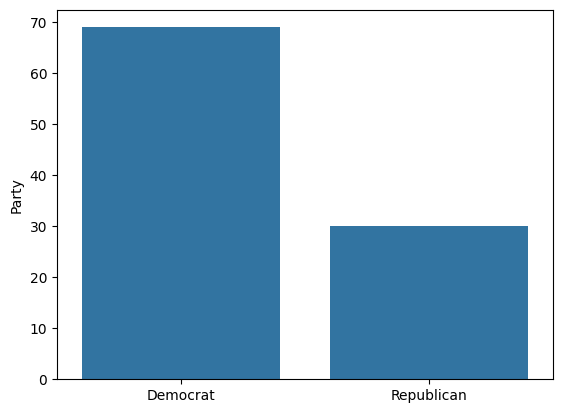

In [14]:
sb.barplot(df_legislator['Party'].value_counts())

In [15]:
df_legislator['Party'].value_counts()

Democrat      69
Republican    30
Name: Party, dtype: int64

In [16]:
df_legislator.explode(['Counties'])

,Name,Occupation,Address,Assignment,Party,Phone Number,District,Counties,Email
0,Judy Amabile,,"200 E ColfaxRM 307Denver, CO 80203United States",Business Affairs & Labor; Appropriations; Legi...,Democrat,303-866-2578,[49],"Boulder, Gilpin, Clear Creek, Larimer",judy.amabile.house@coleg.gov
1,Ryan Armagost,,"200 E ColfaxRM 307Denver, CO 80203United States",Business Affairs & Labor; Legislative Council;...,Republican,303-866-2906,[64],"Larimer, Weld",ryan.armagost.house@coleg.gov
2,Jennifer Bacon,,"200 E ColfaxRM 307Denver, CO 80203United States",Judiciary; Education,Democrat,303-866-2909,[7],Denver,jennifer.bacon.house@coleg.gov
3,Mark Baisley,Aerospace Engineer,"200 E ColfaxRMDenver, CO 80203United States","Business, Labor, & Technology; Joint Technolog...",Republican,303-866-4877,[4],"Chaffee, Douglas, Jefferson, Park, Custer, Fre...",mark.baisley@senate.co.com
4,Shannon Bird,,"200 E ColfaxRM 307Denver, CO 80203United States",Appropriations; Joint Budget Committee,Democrat,303-866-2843,[29],"Adams, Jefferson",shannon.bird.house@coleg.gov
...,...,...,...,...,...,...,...,...,...
95,Faith Winter,,"200 E ColfaxRMDenver, CO 80203United States",Legislative Council; Transportation & Energy; ...,Democrat,303-866-4863,[25],"Adams, Weld, Broomfield",faith.winter.senate@coleg.gov
96,Ty Winter,,"200 E ColfaxRM 307Denver, CO 80203United States","Agriculture, Water & Natural Resources; Energy...",Republican,303-866-2747,[47],"Baca, Crowley, Kiowa, Otero, Pueblo, Bent, Hue...",ty.winter.house@coleg.gov
97,Steven Woodrow,,"200 E ColfaxRM 307Denver, CO 80203United States","State, Civic, Military, & Veterans Affairs; Ju...",Democrat,303-866-2967,[2],Denver,steven.woodrow.house@coleg.gov
98,Mary Young,School Psychologist,"200 E ColfaxRM 307Denver, CO 80203United States",Health & Human Services; Education,Democrat,303-866-2929,[50],Weld,mary.young.house@coleg.gov


In [17]:
pd.get_dummies(df_legislator['Assignment']).value_counts()

Agriculture & Natural Resources; Business, Labor, & Technology  Agriculture & Natural Resources; Judiciary; Committee on Legal Services  Agriculture & Natural Resources; Legislative Council; Finance; Transportation & Energy  Agriculture & Natural Resources; Local Government & Housing; Legislative Audit Committee  Agriculture, Water & Natural Resources  Agriculture, Water & Natural Resources; Business Affairs & Labor  Agriculture, Water & Natural Resources; Capital Development Committee; Transportation, Housing & Local Government  Agriculture, Water & Natural Resources; Energy & Environment  Agriculture, Water & Natural Resources; Energy & Environment; Appropriations  Agriculture, Water & Natural Resources; Health & Human Services  Agriculture, Water & Natural Resources; Legislative Council; Education  Appropriations  Appropriations; Joint Budget Committee  Appropriations; Joint Technology Committee; Committee on Legal Services; Legislative Council; Finance; State, Veterans, & Military 

In [18]:
pd.get_dummies(df_legislator['Assignment'])

,"Agriculture & Natural Resources; Business, Labor, & Technology",Agriculture & Natural Resources; Judiciary; Committee on Legal Services,Agriculture & Natural Resources; Legislative Council; Finance; Transportation & Energy,Agriculture & Natural Resources; Local Government & Housing; Legislative Audit Committee,"Agriculture, Water & Natural Resources","Agriculture, Water & Natural Resources; Business Affairs & Labor","Agriculture, Water & Natural Resources; Capital Development Committee; Transportation, Housing & Local Government","Agriculture, Water & Natural Resources; Energy & Environment","Agriculture, Water & Natural Resources; Energy & Environment; Appropriations","Agriculture, Water & Natural Resources; Health & Human Services",...,Local Government & Housing; Transportation & Energy,Pension Review Subcommittee; Education; Health & Human Services,"State, Civic, Military, & Veterans Affairs; Judiciary","State, Civic, Military, & Veterans Affairs; Statutory Revision Committee","State, Veterans, & Military Affairs; Appropriations; Legislative Council; Business, Labor, & Technology","State, Veterans, & Military Affairs; Business, Labor, & Technology",Statutory Revision Committee; Agriculture & Natural Resources; Local Government & Housing; Capital Development Committee; Transportation & Energy,Transportation & Energy; Health & Human Services,"Transportation, Housing & Local Government; Agriculture, Water & Natural Resources; Capital Development Committee","Transportation, Housing & Local Government; Energy & Environment"
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
97,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
df_legislator['Assignment'].str.split('; ',expand=True)


,0,1,2,3,4,5
0,Business Affairs & Labor,Appropriations,Legislative Council,Judiciary,None,None
1,Business Affairs & Labor,Legislative Council,Judiciary,None,None,None
2,Judiciary,Education,None,None,None,None
3,"Business, Labor, & Technology",Joint Technology Committee,Education,"State, Veterans, & Military Affairs",None,None
4,Appropriations,Joint Budget Committee,None,None,None,None
...,...,...,...,...,...,...
95,Legislative Council,Transportation & Energy,Local Government & Housing,None,None,None
96,"Agriculture, Water & Natural Resources",Energy & Environment,None,None,None,None
97,"State, Civic, Military, & Veterans Affairs",Judiciary,None,None,None,None
98,Health & Human Services,Education,None,None,None,None


In [20]:
assignment_dummies = df_legislator['Assignment'].str.get_dummies(sep='; ') #Ajacentcy Matrix
assignment_dummies
# making a network graph

,Agriculture & Natural Resources,"Agriculture, Water & Natural Resources",Appropriations,Business Affairs & Labor,"Business, Labor, & Technology",Capital Development Committee,Capitol Building Advisory Committee,Committee on Legal Services,Education,Energy & Environment,...,Judiciary,Legislative Audit Committee,Legislative Council,Local Government & Housing,Pension Review Subcommittee,"State, Civic, Military, & Veterans Affairs","State, Veterans, & Military Affairs",Statutory Revision Committee,Transportation & Energy,"Transportation, Housing & Local Government"
0,0,0,1,1,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,1,0
96,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
97,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
98,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
assignment_dummies

currentheaders = list(assignment_dummies.columns.values)
len(currentheaders)
currentheaders

['Agriculture & Natural Resources',
 'Agriculture, Water & Natural Resources',
 'Appropriations',
 'Business Affairs & Labor',
 'Business, Labor, & Technology',
 'Capital Development Committee',
 'Capitol Building Advisory Committee',
 'Committee on Legal Services',
 'Education',
 'Energy & Environment',
 'Executive Committee of the Legislative Council',
 'Finance',
 'Health & Human Services',
 'Joint Budget Committee',
 'Joint Technology Committee',
 'Judiciary',
 'Legislative Audit Committee',
 'Legislative Council',
 'Local Government & Housing',
 'Pension Review Subcommittee',
 'State, Civic, Military, & Veterans Affairs',
 'State, Veterans, & Military Affairs',
 'Statutory Revision Committee',
 'Transportation & Energy',
 'Transportation, Housing & Local Government']

In [22]:
df_dirty = df_legislator['Counties'].str.get_dummies(sep=', ') #Ajacentcy Matrix
df_dirty

,Arapahoe'],Archuleta,Bent,Broomfield'],Cheyenne,Clear Creek,Conejos,Costilla,Crowley,Custer,...,['Eagle,['El Paso,['El Paso'],['Jefferson'],['Larimer,['Larimer'],['Logan,['Mesa'],['Pueblo'],['Weld']
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [23]:
currentheaders = list(df_dirty.columns.values)
len(currentheaders)

94

In [24]:
cleanedheaders = str.strip 
cleanedheaders

<method 'strip' of 'str' objects>

In [25]:
# some small data cleaning
df_dirty.columns = df_dirty.columns.str.strip().str.replace("[\[\]']", "", regex=True)
# Remove duplicate columns
df_counties_cleaned = df_dirty.loc[:, ~df_dirty.columns.duplicated()]


In [26]:
currentheaders = list(df_counties_cleaned.columns.values)
len(currentheaders)

64

In [27]:
df_counties_cleaned

df_counties_people = pd.concat([df_legislator['Name'],df_counties_cleaned], axis=1)
df_counties_people

,Name,Arapahoe,Archuleta,Bent,Broomfield,Cheyenne,Clear Creek,Conejos,Costilla,Crowley,...,Washington,Weld,Yuma,Adams,Alamosa,Baca,Boulder,Chaffee,Delta,Logan
0,Judy Amabile,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,Ryan Armagost,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Jennifer Bacon,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Mark Baisley,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Shannon Bird,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Faith Winter,0,0,0,1,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
96,Ty Winter,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
97,Steven Woodrow,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98,Mary Young,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
df_combined = pd.concat([df_legislator['Name'],assignment_dummies,df_counties_cleaned], axis=1)
df_combined

,Name,Agriculture & Natural Resources,"Agriculture, Water & Natural Resources",Appropriations,Business Affairs & Labor,"Business, Labor, & Technology",Capital Development Committee,Capitol Building Advisory Committee,Committee on Legal Services,Education,...,Washington,Weld,Yuma,Adams,Alamosa,Baca,Boulder,Chaffee,Delta,Logan
0,Judy Amabile,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,Ryan Armagost,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Jennifer Bacon,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,Mark Baisley,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,Shannon Bird,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Faith Winter,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
96,Ty Winter,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
97,Steven Woodrow,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98,Mary Young,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


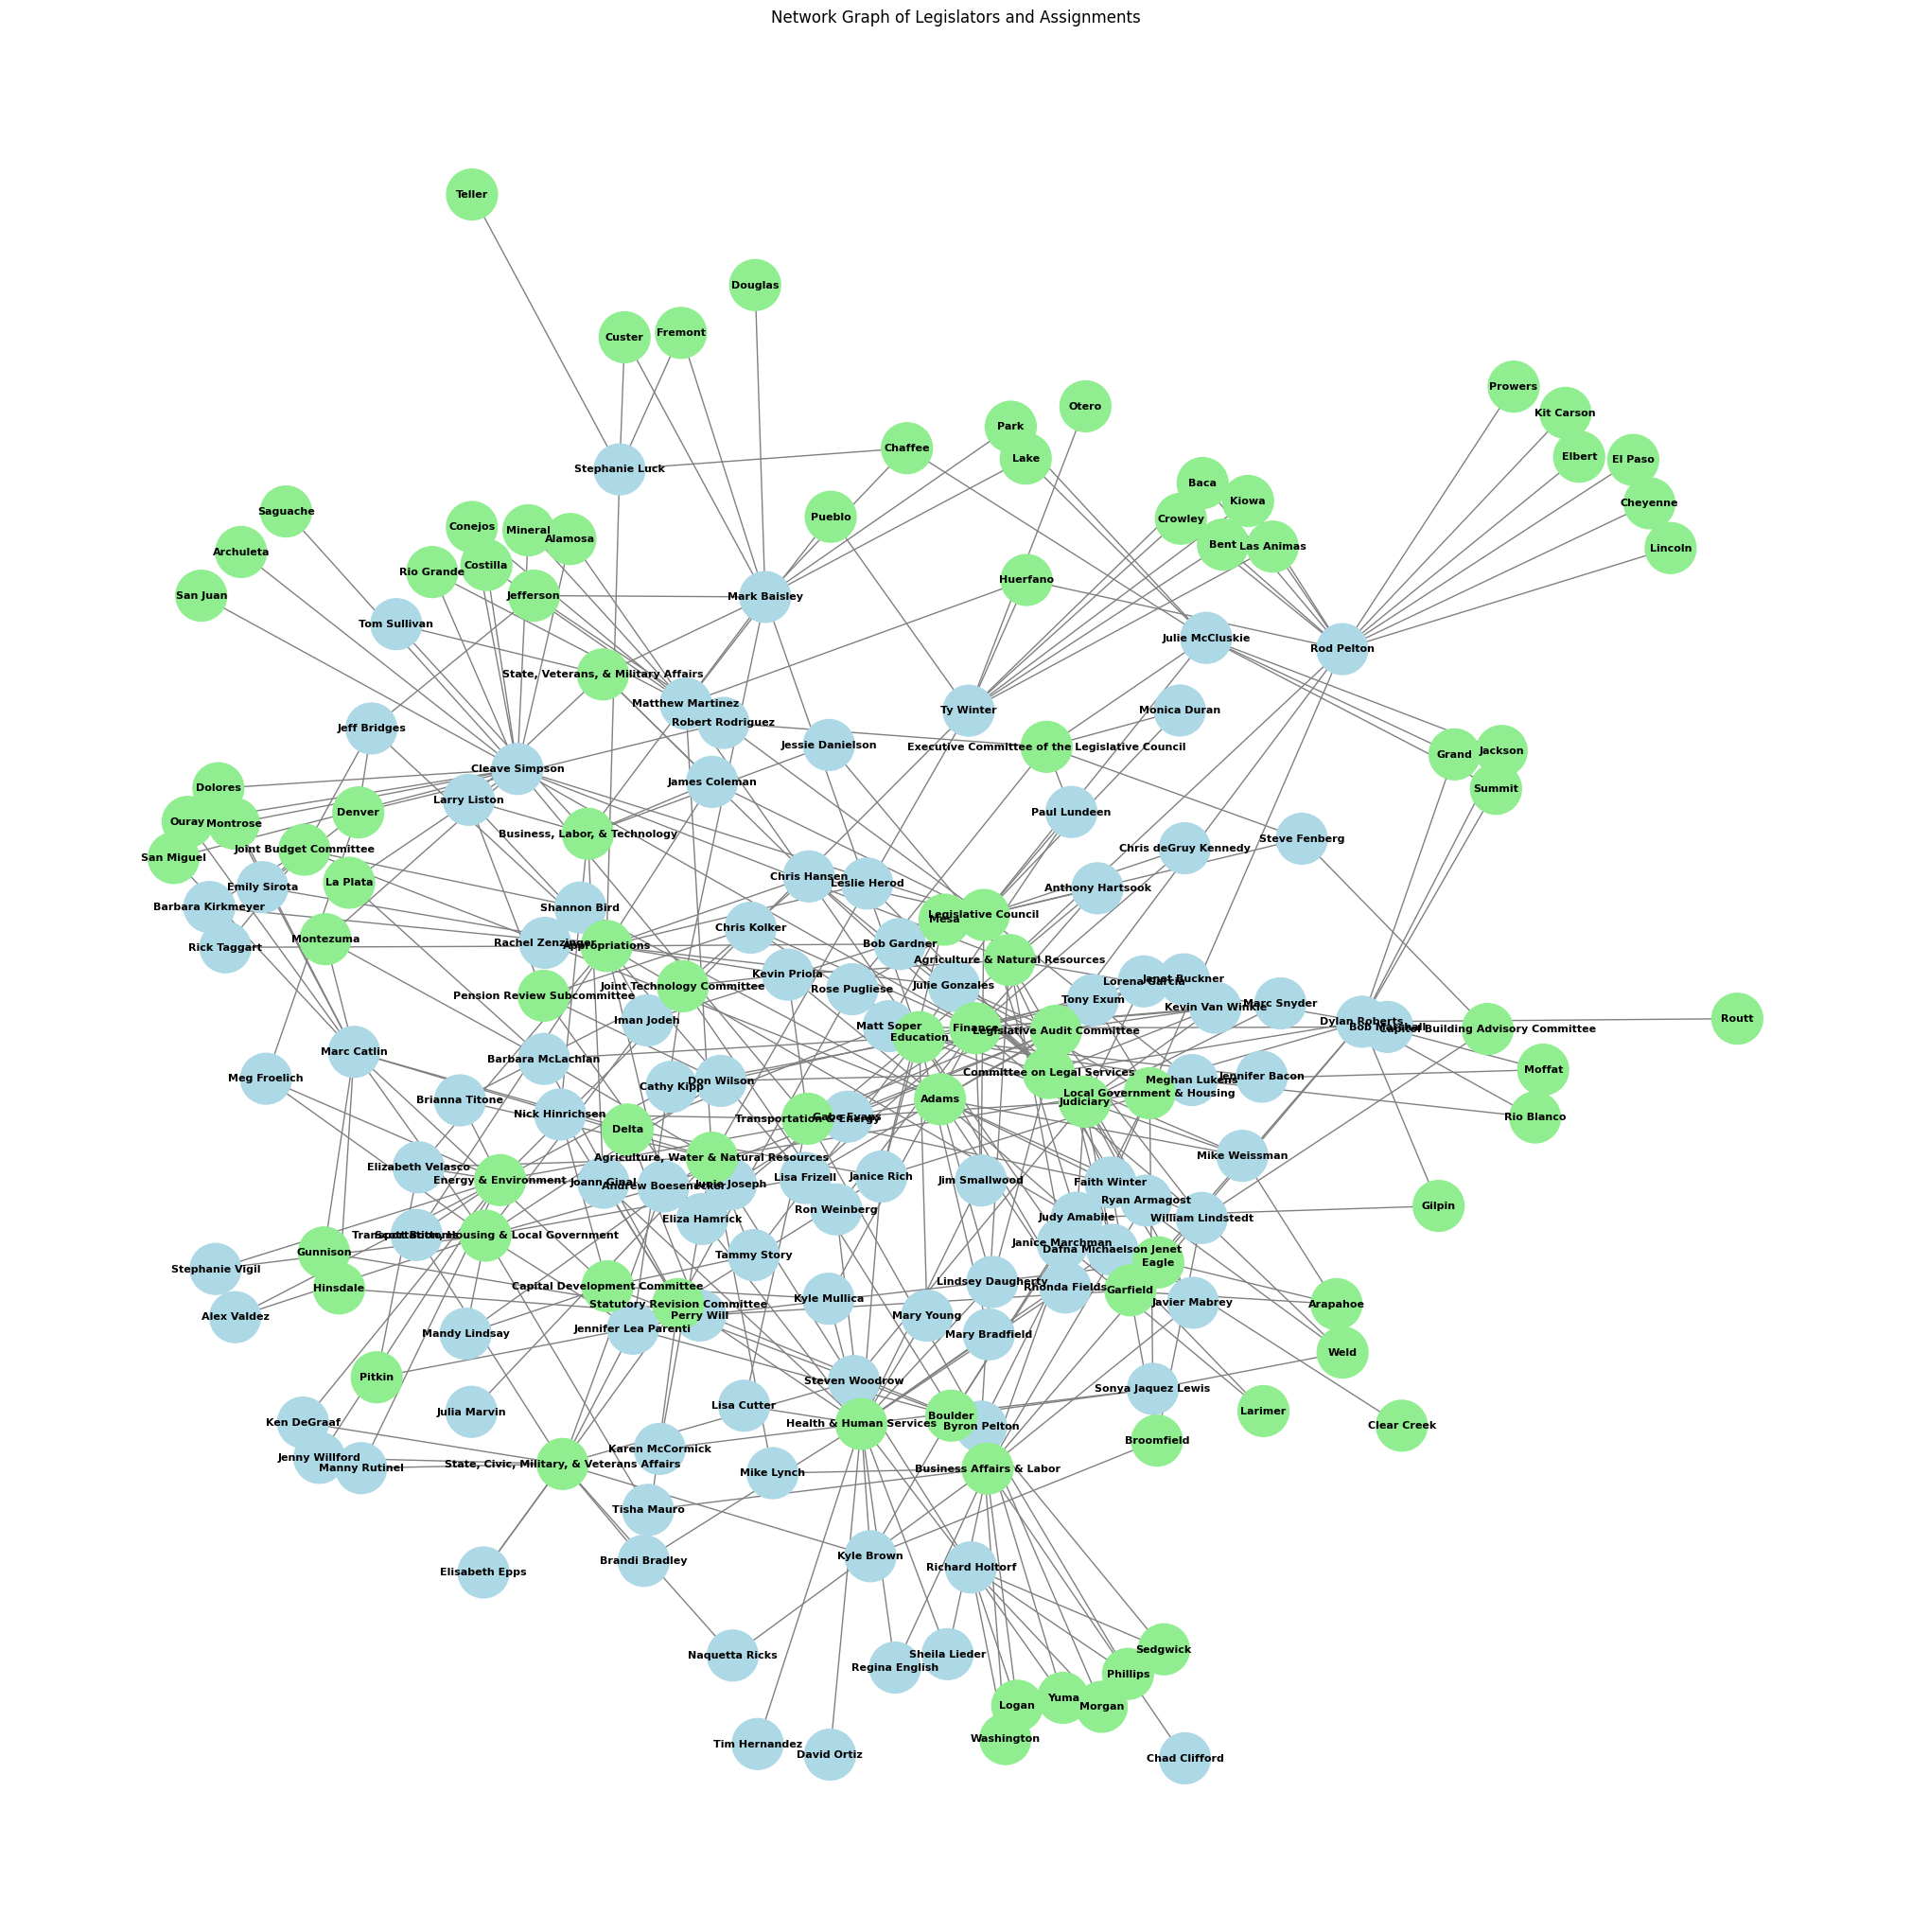

In [93]:
# bipartite graph

# Documentation : https://networkx.org/documentation/stable/tutorial.html
G = nx.Graph()

# Get the legislator names
legislators = df_combined['Name'].tolist()

# Get the assignment/committee names (excluding the 'Name' column)
assignments = df_combined.columns.tolist()[1:]

# Add legislators as one set of nodes
G.add_nodes_from(legislators, bipartite=0) 

G.add_nodes_from(assignments, bipartite=1) 

# Create edges between legislators and the committees they belong to
for i in range(df_combined.shape[0]):  
    legislator = df_combined.iloc[i]['Name']
    for assignment in assignments:
        if df_combined.iloc[i][assignment] == 1:  # If the legislator belongs to the committee
            G.add_edge(legislator, assignment)


plt.figure(figsize=(20, 20))

# Positioning for a bipartite graph
pos = nx.spring_layout(G, seed=42)

legislator_color = "lightblue"
assignment_color = "lightgreen"


node_colors = [legislator_color if node in legislators else assignment_color for node in G.nodes()]


nx.draw(G, pos, with_labels=True, node_size=1500, node_color=node_colors, font_size=8, font_weight="bold", edge_color="gray")

plt.title("Network Graph of Legislators and Assignments")
plt.show()


In [89]:
df_assingment_people = pd.concat([df_legislator['Name'],assignment_dummies], axis=1)
df_assingment_people

,Name,Agriculture & Natural Resources,"Agriculture, Water & Natural Resources",Appropriations,Business Affairs & Labor,"Business, Labor, & Technology",Capital Development Committee,Capitol Building Advisory Committee,Committee on Legal Services,Education,...,Judiciary,Legislative Audit Committee,Legislative Council,Local Government & Housing,Pension Review Subcommittee,"State, Civic, Military, & Veterans Affairs","State, Veterans, & Military Affairs",Statutory Revision Committee,Transportation & Energy,"Transportation, Housing & Local Government"
0,Judy Amabile,0,0,1,1,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
1,Ryan Armagost,0,0,0,1,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
2,Jennifer Bacon,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
3,Mark Baisley,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,Shannon Bird,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Faith Winter,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,1,0
96,Ty Winter,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97,Steven Woodrow,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
98,Mary Young,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


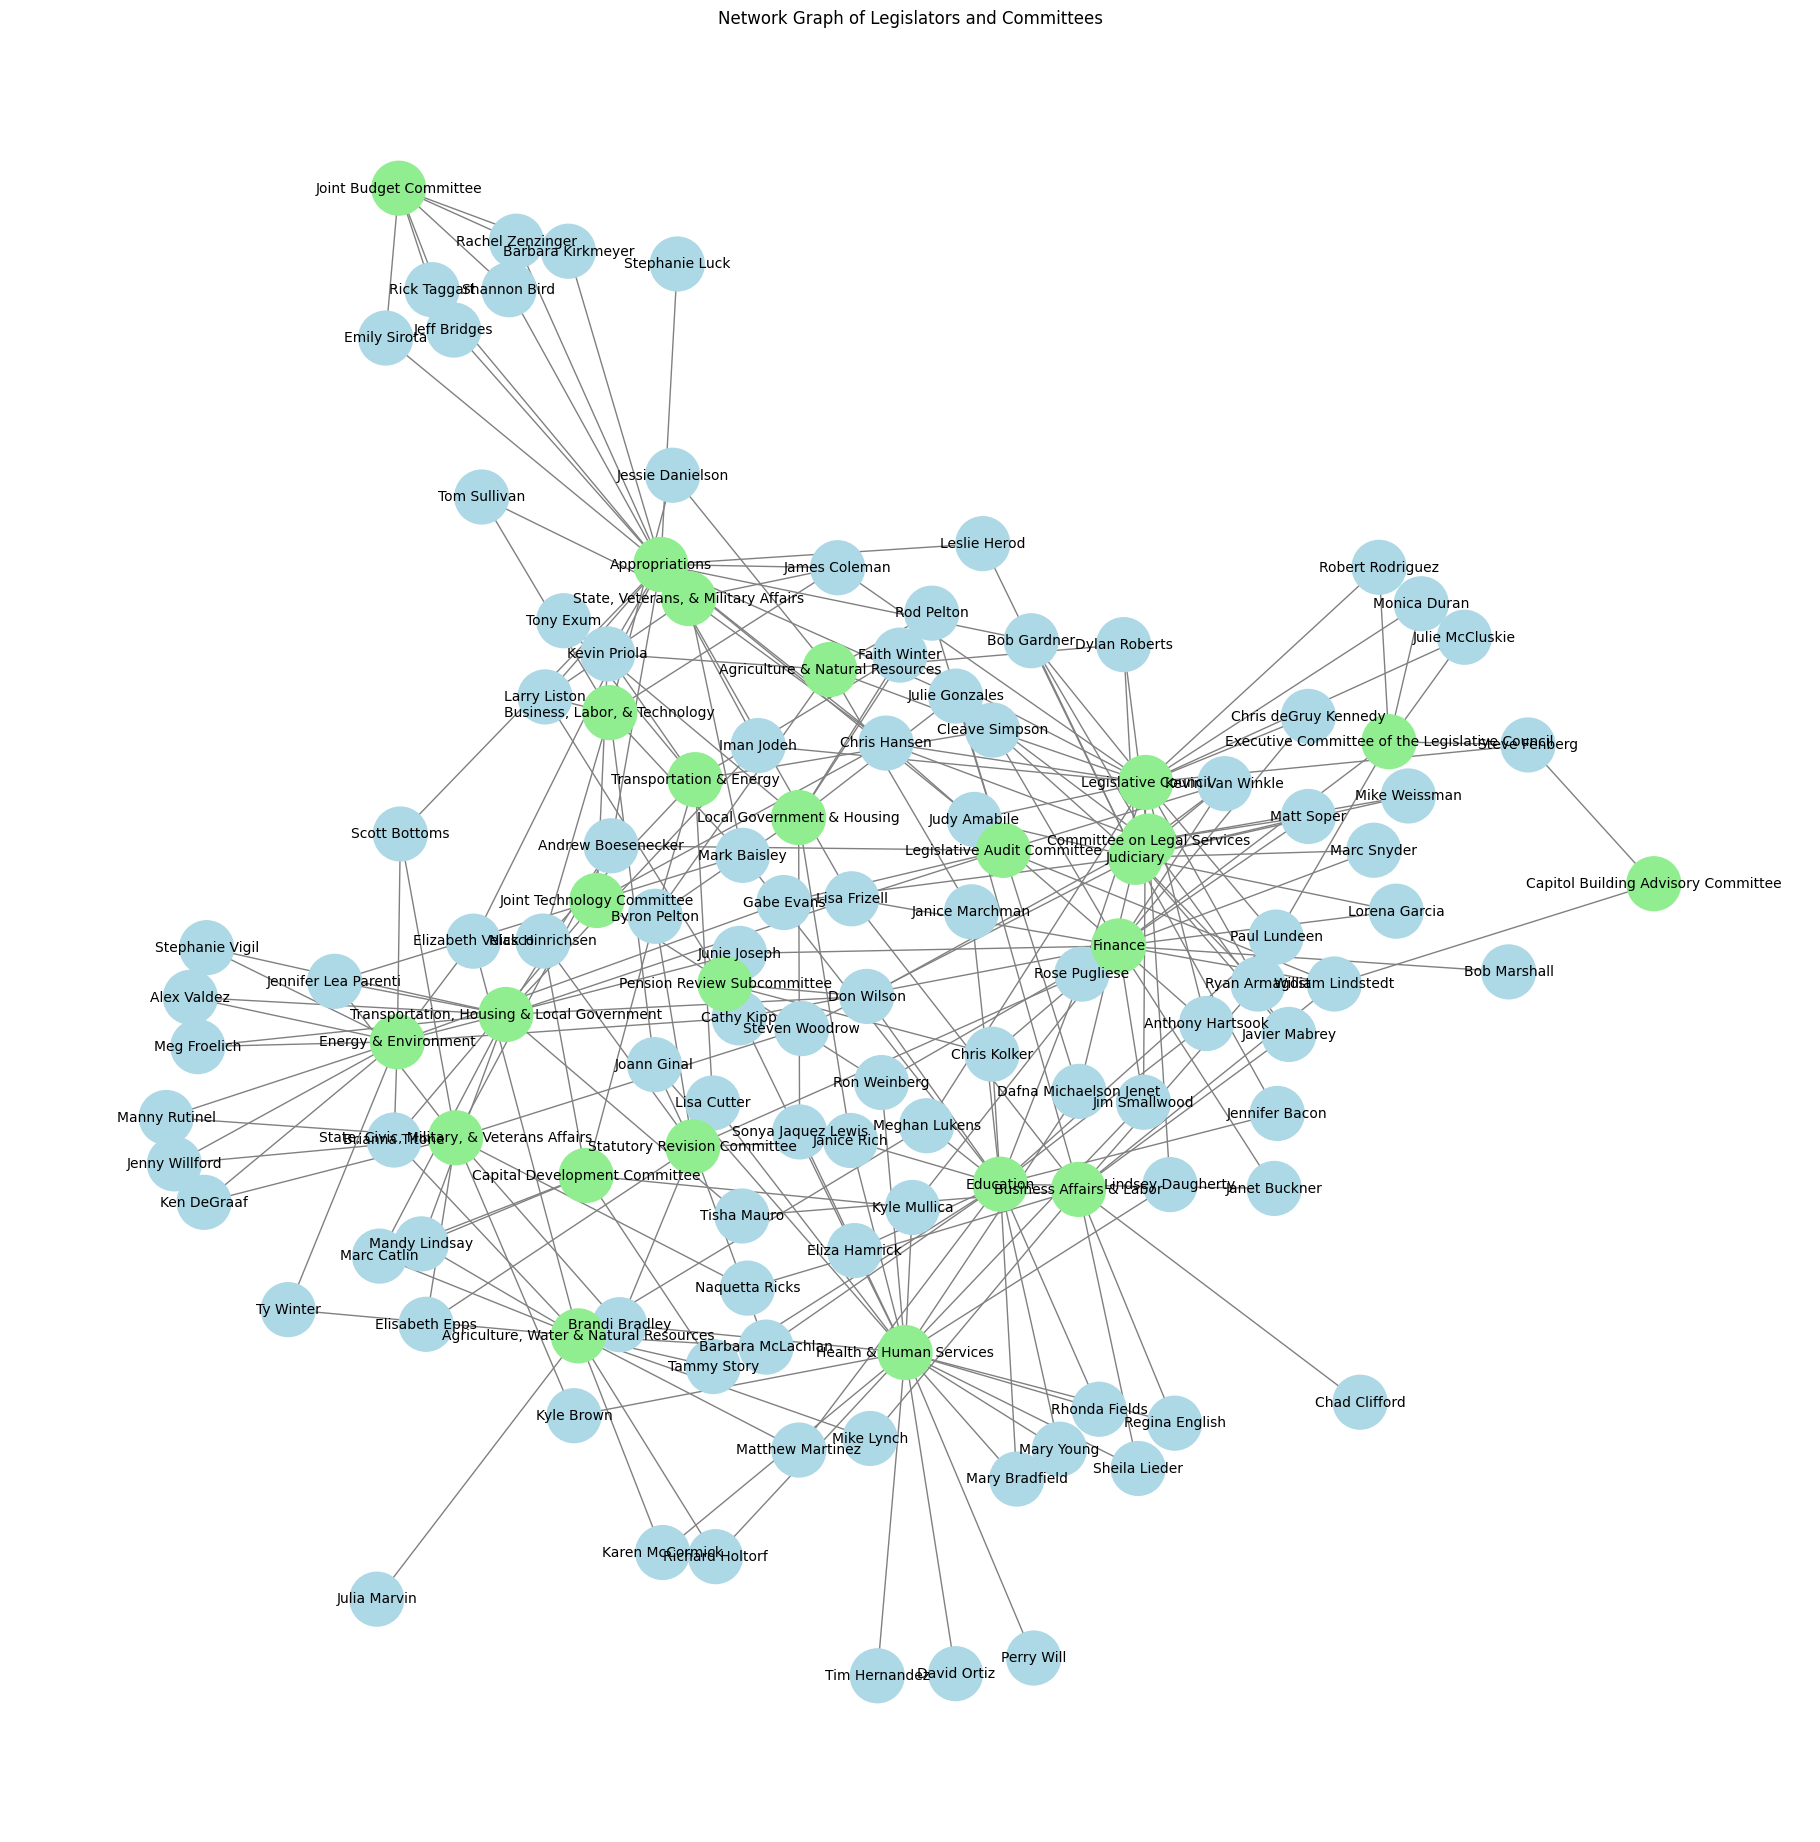

In [127]:
# bipartite graph depicting legislator and committee


G = nx.Graph()

legislators = df_assingment_people['Name'].tolist()

assignments = df_assingment_people.columns.tolist()[1:]

G.add_nodes_from(legislators, bipartite=0)

G.add_nodes_from(assignments, bipartite=1)  

# Create edges between legislators and the committees they belong to
for i in range(df_assingment_people.shape[0]): 
    legislator = df_combined.iloc[i]['Name']  
    for assignment in assignments:
        if df_combined.iloc[i][assignment] == 1:  # If the legislator belongs to the committee
            G.add_edge(legislator, assignment)

plt.figure(figsize=(18, 18))

pos = nx.spring_layout(G, seed=42)

legislator_color = "lightblue"
assignment_color = "lightgreen"

node_colors = [legislator_color if node in legislators else assignment_color for node in G.nodes()]

nx.draw(G, pos, with_labels=True, node_size=1500, node_color=node_colors, font_size=10, edge_color="gray")

plt.title("Network Graph of Legislators and Committees")
plt.show()


In [111]:
df_counties_people.head(30)

,Name,Arapahoe,Archuleta,Bent,Broomfield,Cheyenne,Clear Creek,Conejos,Costilla,Crowley,...,Washington,Weld,Yuma,Adams,Alamosa,Baca,Boulder,Chaffee,Delta,Logan
0,Judy Amabile,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,Ryan Armagost,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Jennifer Bacon,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Mark Baisley,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Shannon Bird,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
6,Andrew Boesenecker,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Scott Bottoms,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,Mary Bradfield,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,Brandi Bradley,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,Jeff Bridges,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
# towns_managed_by_legislators = df_counties_people.set_index('Name').sum(axis=1)
# towns_managed_by_legislators

In [33]:
# plt.figure(figsize=(13,5))
# sb.barplot(towns_managed_by_legislators.sort_values( ascending=False))
# plt.xticks(rotation=90);

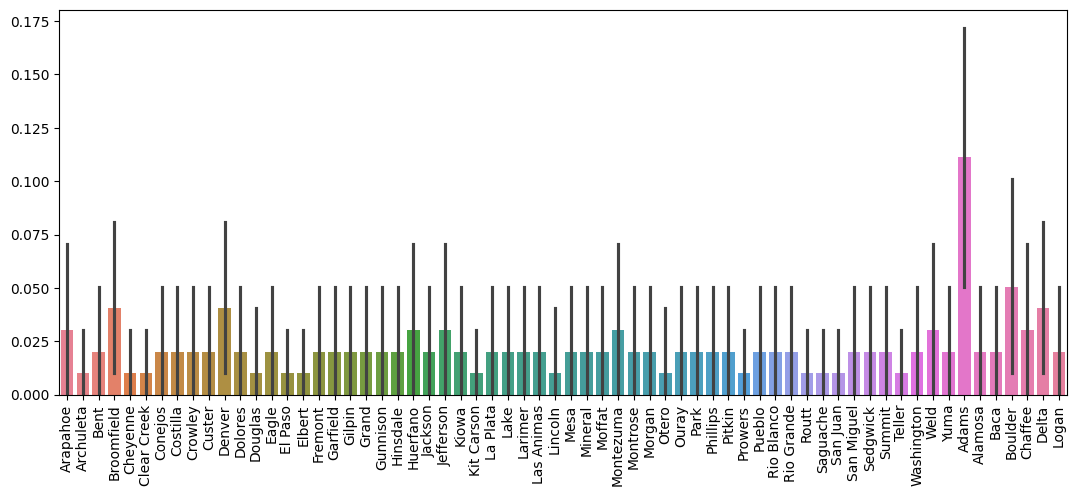

In [130]:
plt.figure(figsize=(13,5))
sb.barplot(df_counties_people)
plt.xticks(rotation=90);


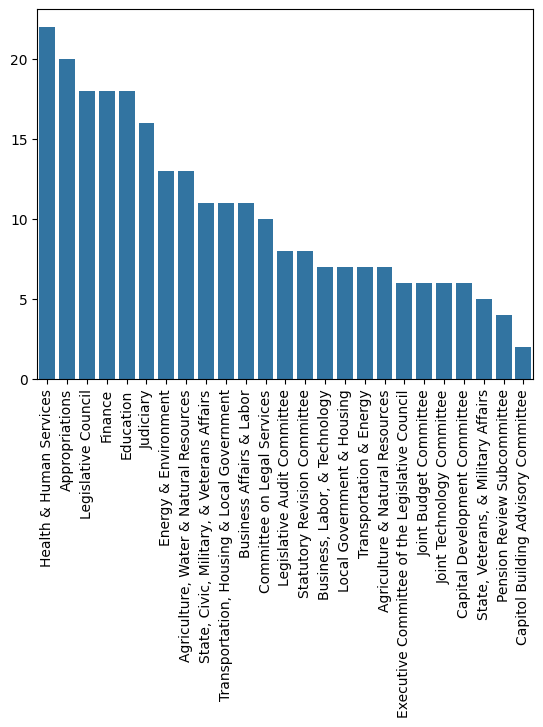

In [36]:
assignment_df = assignment_dummies.sum(axis='rows') #the amount of commite for each person
assignment_df
df_sorted = assignment_df.sort_values( ascending=False)
df_sorted
sb.barplot(data=(df_sorted),)
plt.xticks(rotation=90)
plt.show()